In [1]:
import pandas as pd


print("Reading file...")
all_df = pd.read_csv('./data.csv', low_memory=False)
print("Done reading!")

Reading file...
Done reading!


In [2]:
# Sanity Check
print(all_df.keys())

Index(['steamId', 'itadPlain', 'itad.position', 'itad.rank', 'steam.name',
       'steam.steam_appid', 'steam.required_age', 'steam.is_free', 'steam.dlc',
       'steam.reviews',
       ...
       'steam.short_description.compound', 'steam.ext_user_account_notice',
       'timestamp', 'year', 'month', 'day', 'daysSinceLaunch', 'price',
       'percentOfReleasePrice', 'isSteamSale'],
      dtype='object', length=131)


In [3]:
pd.to_datetime(all_df['timestamp'] * 1000000000)

0         2016-02-20 00:30:00
1         2016-02-21 00:30:00
2         2016-02-22 00:30:00
3         2016-02-23 00:30:00
4         2016-02-24 00:30:00
                  ...        
4914984   2022-03-02 00:30:00
4914985   2022-03-03 00:30:00
4914986   2022-03-04 00:30:00
4914987   2022-03-05 00:30:00
4914988   2022-03-06 00:30:00
Name: timestamp, Length: 4914989, dtype: datetime64[ns]

In [4]:
all_df.dtypes

steamId                    int64
itadPlain                 object
itad.position              int64
itad.rank                  int64
steam.name                object
                          ...   
day                        int64
daysSinceLaunch            int64
price                    float64
percentOfReleasePrice    float64
isSteamSale                 bool
Length: 131, dtype: object

In [5]:
all_df['time'] = pd.to_datetime(all_df['timestamp'] * 1000000000)

In [6]:
all_df['time']

0         2016-02-20 00:30:00
1         2016-02-21 00:30:00
2         2016-02-22 00:30:00
3         2016-02-23 00:30:00
4         2016-02-24 00:30:00
                  ...        
4914984   2022-03-02 00:30:00
4914985   2022-03-03 00:30:00
4914986   2022-03-04 00:30:00
4914987   2022-03-05 00:30:00
4914988   2022-03-06 00:30:00
Name: time, Length: 4914989, dtype: datetime64[ns]

In [7]:
all_df = all_df.rename({'time': 'ds', 'percentOfReleasePrice': 'y'}, axis='columns')

We want to predict `percentOfReleasePrice` instead of just `price` because of the following:
  - games can start at many prices
  - the starting price of a game is variable (changes over time)
    - e.g. a AAA game in 2015 released at $60, now the base release price is $80
    - It usually jumps in 5-10 dollar increments to keep the consumer happy.
    - @christian can you please find a citation for this or similar metric? Basically want to say that there is a trend in price (but trend is discrete as well)
  - Game launch price is immediately available, if the game is available
    - It's also very easy to translate an absolute price (e.g. $20) into a % of the release price, so it stays user-friendly as well.
  - If we normalize, we'll be able to generalize more (it's more effective when predicting between 0 and 1, rather than having a varying range)
    - We should be normalizing data anyway for ML lol

<AxesSubplot:>

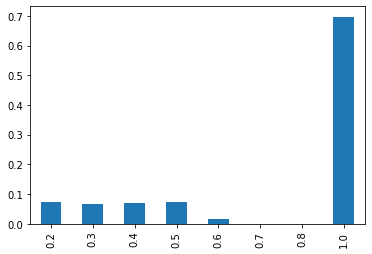

In [8]:
# Look at the average proportions of how the prices are distributed
all_df['y'].round(decimals=1).value_counts(normalize=True).sort_index().plot(kind='bar')

<AxesSubplot:>

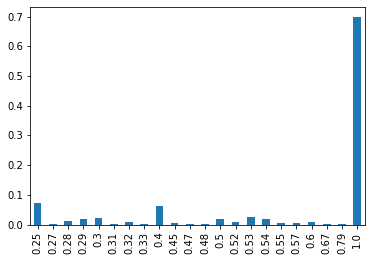

In [9]:
all_df['y'].round(decimals=2).value_counts(normalize=True).sort_index().plot(kind='bar')

We can see that most games for most of the time like to stay at their original release price.
There are no games that have increased in price.
Games do not like 20%, 30% discounts, but rather like having stuff at 20-50% of its original price.
Discount percentage prefers to be in a nice, human-readable number (0.25, 0.4, 0.5)
  - 0.53, 0.54 disprove this rule

In [10]:
# Split each game into its own dataframe for easier forecasting
dfs = [v for k, v in all_df.groupby('itadPlain')]
len(dfs)

2227

In [11]:
# One dataframe per game, in a list.
dfs[0].head()

,steamId,itadPlain,itad.position,itad.rank,steam.name,steam.steam_appid,steam.required_age,steam.is_free,steam.dlc,steam.reviews,...,steam.ext_user_account_notice,timestamp,year,month,day,daysSinceLaunch,price,y,isSteamSale,ds
3023590,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.455928e+09,2016,2,20,0,19.99,1.0,False,2016-02-20 00:30:00
3023591,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456015e+09,2016,2,21,1,19.99,1.0,False,2016-02-21 00:30:00
3023592,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456101e+09,2016,2,22,2,19.99,1.0,False,2016-02-22 00:30:00
3023593,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456187e+09,2016,2,23,3,19.99,1.0,False,2016-02-23 00:30:00
3023594,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456274e+09,2016,2,24,4,19.99,1.0,False,2016-02-24 00:30:00


In [12]:
# Let's try to naively throw our data into FB Prophet, and see what it spits out.

from prophet import Prophet

m = Prophet()
m.fit(dfs[0])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -134.097


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       2068.92   0.000727766       79.1295   1.004e-05       0.001      144  LS failed, Hessian reset 
      99       2068.96   1.77372e-06        57.234      0.6525      0.2032      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       2068.96   2.06127e-05       50.6233   2.904e-07       0.001      253  LS failed, Hessian reset 
     138       2068.96   2.29474e-08       45.4581     0.03656      0.9634      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [13]:
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2567,2023-03-02 00:30:00,0.722384,0.429965,1.005272
2568,2023-03-03 00:30:00,0.690779,0.410755,0.982463
2569,2023-03-04 00:30:00,0.671051,0.373453,0.968784
2570,2023-03-05 00:30:00,0.649332,0.345878,0.962144
2571,2023-03-06 00:30:00,0.631082,0.339108,0.950407


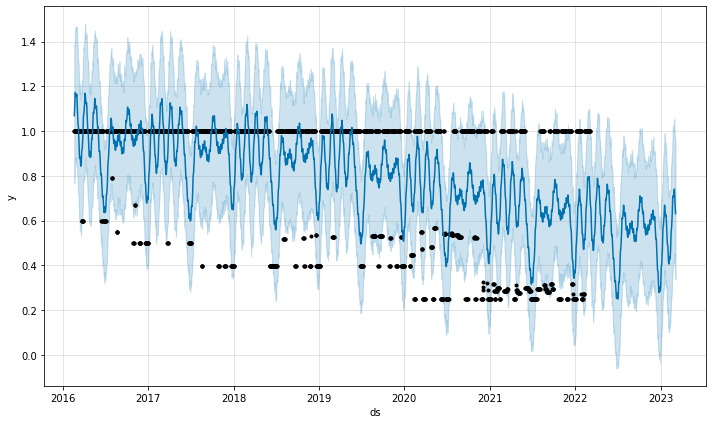

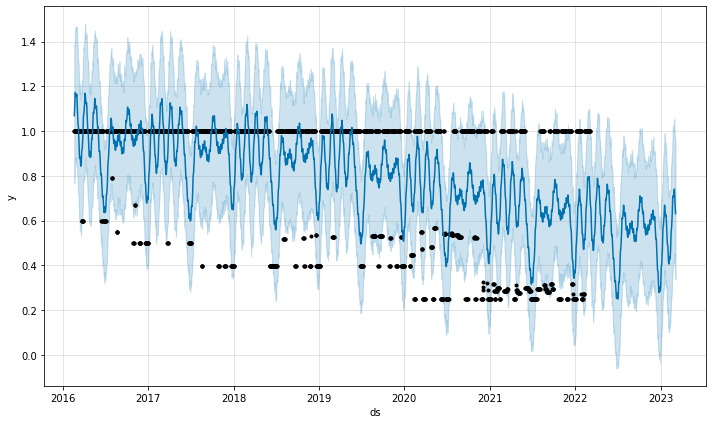

In [14]:
m.plot(forecast)

Hmm uhh..... This doesn't look good. Let's just look at the seasonal components for good measure.

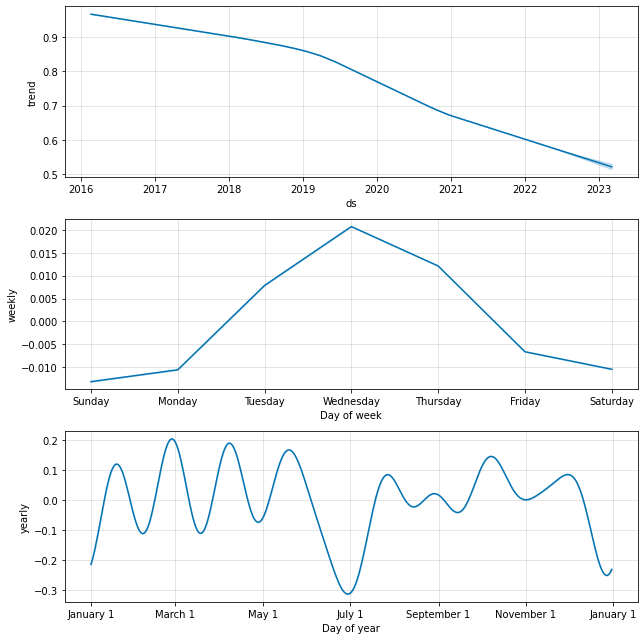

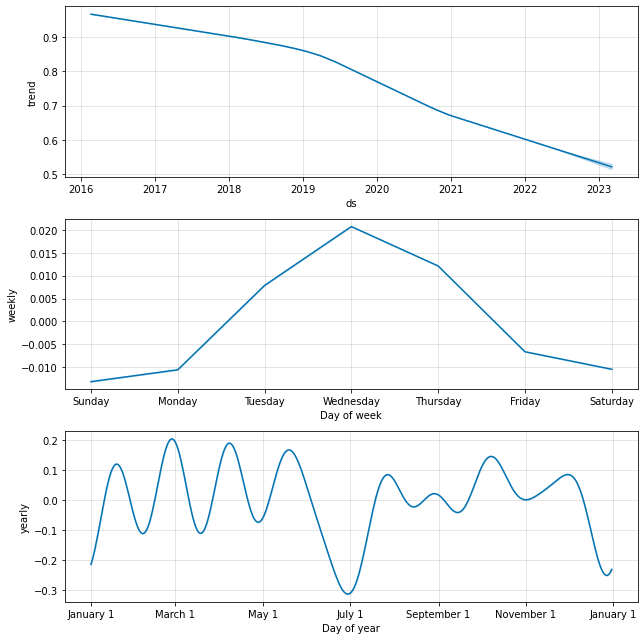

In [15]:
m.plot_components(forecast)

Looks very suspicious. This should definitely not be happening. Ideally, we'd see

In [16]:
# Let's just try it again with another game to make sure.
m = Prophet()
m.fit(dfs[1732])
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -134.097
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       2068.92   0.000727766       79.1295   1.004e-05       0.001      144  LS failed, Hessian reset 
      99       2068.96   1.77372e-06        57.234      0.6525      0.2032      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       2068.96   2.06127e-05       50.6233   2.904e-07       0.001      253  LS failed, Hessian reset 
     138       2068.96   2.29474e-08       45.4581     0.03656      0.9634      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,ds,yhat,yhat_lower,yhat_upper
2567,2023-03-02 00:30:00,0.722384,0.417590,1.021373
2568,2023-03-03 00:30:00,0.690779,0.389227,0.983278
2569,2023-03-04 00:30:00,0.671051,0.372744,0.965752
2570,2023-03-05 00:30:00,0.649332,0.328294,0.940604
2571,2023-03-06 00:30:00,0.631082,0.310501,0.947027


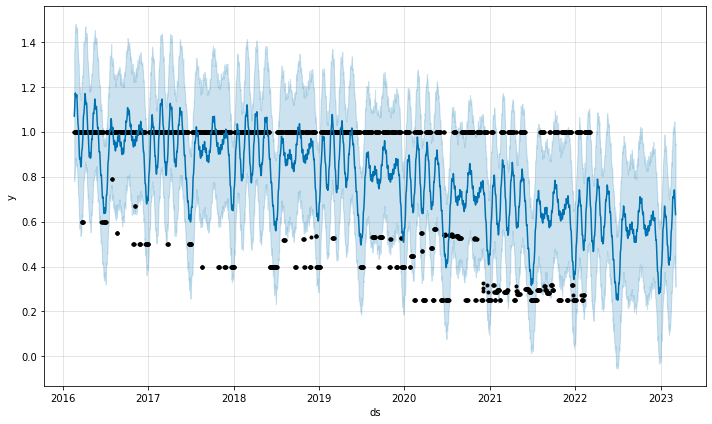

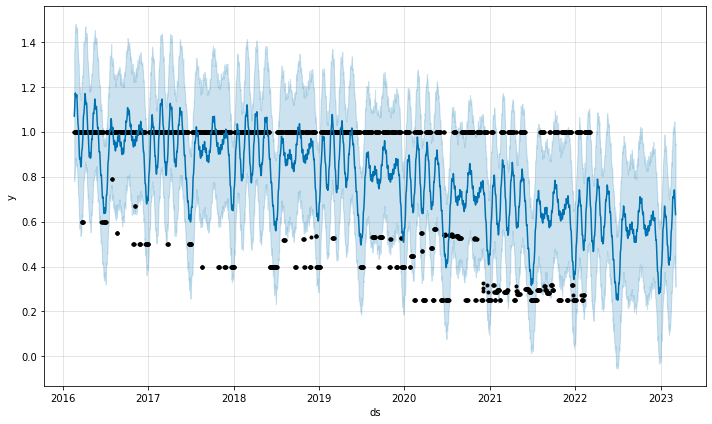

In [17]:
m.plot(forecast)

As we can see, this wasn't very good either. This is probably because sales are always discrete (jump from 100% to 40% price in a day, then jumping back up immediately.) For Prophet, as well as other ML models and the traditional methods (ARIMA, SARIMA, Holt-Winter) both expect a rather continuous distribution.

Let's take another look at our problem again.

We want to be able to predict the prices of games, yes, but why do we want that? We want to predict the prices so that users can decide whether they want to wait or not in order to get a game at a certain price.

That means that the actual proportion of time in a given sliding window (or a given time period) does not matter. Only if it reached it.

This reasoning gives us 3 options (all done using sliding windows of 7, 30, 90, 180 days):
 - Bucket the `percentOfOriginalPrice` into intervals of 0.8 or 0.1, and predict whether a given interval will show up
    - This is just logistic regression a bunch of times isn't it.
    - I predict that this one will work the best, and will be the most usable.
 - If we actually care about proportion of time it will show up, we can make it show the % of the sliding window being in a given bucket.
    - This will make the data more continuous (as data enters the sliding window it will slowly change the % values), but at the same time, we don't really care about the % of time that a game is a given price. Just that it reaches a cheap enough price.
    - If we make it continuous, we should be able to use the original models we wanted to use (Prophet, SARIMA, etc)
 - Our "original" idea, which is to:
   - cluster games by trends (k-mean or som)
     - SOM = self-organizing map
        - https://github.com/JustGlowing/minisom
        - https://www.kaggle.com/code/izzettunc?scriptVersionId=56314361&cellId=37
     - Dynamic time barycenter averaging
       - https://www.kaggle.com/code/izzettunc?scriptVersionId=56314361&cellId=44
       - ts-learn
       - Extra important because new games will be coming in at different times, however will still most likely follow the same trends (e.g. get to half price by the end of 3 years)
         - alternatively, we could use "Days since launch" column instead of timestamp as a way to phase time since launch date.
     - k-means
       - use DTW (dynamic time warping)
       - Either way, we try to follow the clustering ideas presented in the Kaggle notebook.
   - from those group results, run a rule-finder or make a classifier so that we can find a trend, given a game's attributes (e.g. multiplayer, supports linux, has 2 developers)
   - Run the classifier, then use that trend model to predict.

In [18]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

import numpy as np

onlyTrend = []

# X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])

for df in dfs:
    onlyTrend.append(df['y'])

hehe = np.array(onlyTrend)


print(len(onlyTrend), len(onlyTrend[0]))

2227 2207


In [19]:
# len(onlyTrend[0])

In [20]:
hehe

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

## Let's try out a bunch of clustering modules from tslearn


In [21]:
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
import datetime


seed = 44
np.random.seed(seed)

def benchmark_train_model(length=100,max_iter=10):
    start = datetime.datetime.now()
    print(f"[BENCH] starting model benchmark, length={length}, max_iter={max_iter}")
    model = TimeSeriesKMeans(n_clusters=10, metric="dtw", n_jobs=-1, max_iter=max_iter, random_state=seed)
    model.fit(onlyTrend[0:length])
    end = datetime.datetime.now()
    print("[BENCH] done!", (end-start))
    return model

In [22]:
# Experiment 1
# Trying to find out how the TimeSeriesKMeans clustering scales
# Hypothesis: Potentially O(n) or O(n^2), because it might have to compare all the values with another? Not too sure how time series clustering would work.
# Result: It scales linearly O(n). If our dataset has 2227 games, and 100 games takes 7 minutes, then it will take around 2.56h for the entire set to be fitted.
model_100 = benchmark_train_model(100)
model_200 = benchmark_train_model(200)

[BENCH] starting model benchmark, length=100, max_iter=10


KeyboardInterrupt: 

In [ ]:
# Experiment 2
# Trying to find out how max iterations affects clustering times
# Hypothesis: Each iteration should take the same amount of time, and therefore should scale linearly.
# Result: It ended up taking roughly the same amount of time. Maybe this is because it actually converged properly with 10 iterations?

# Experiment 3
# Trying to find out how iterations affect the end result
# Hypothesis: More iterations (50), should have more effective classification than 10 iterations.
# Result:
model_m50 = benchmark_train_model(100, 50)


In [23]:
model_m50.to_json('./temp-kmeans-model.json')


NameError: name 'model_m50' is not defined

In [28]:
model_m50 = TimeSeriesKMeans.from_json('./temp-kmeans-model.json')
y_pred = model_m50.predict(onlyTrend[0:200])



/Users/kevin/PycharmProjects/msci-446/working/venv38/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 200 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [ ]:
y_pred

In [25]:
import matplotlib.pyplot as plt

def plot_model_classes(model):
    plt.figure(figsize=(18,10))
    for yi in range(10):
        plt.subplot(4, 4, 1 + yi, autoscalex_on=True)
        ok_ind = [y_pred[0:200] == yi][0]
        sub =  onlyTrend[0:200]
        for ind, xx in enumerate(sub):
            if ok_ind[ind]:
                plt.plot(np.array(xx).ravel(), "k-", alpha=.2)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1.1)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("DBA $k$-means")



In [26]:
plot_model_classes(model_m50)

NameError: name 'model_m50' is not defined

## Supervised learning. 
Our current ideas to do supervised learning are:
 - Using a basic Markov chain (looks at training data to build up frequencies)
 - Using linear regression to predict 
 - Using the classifier to predict what will happen (based on past trends)